In [1]:
import os
import re
import gzip
import nibabel as nib
from PIL import Image
import cv2

import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from CompositionalNets.Code.config import vc_num
from CompositionalNets.Initialization_Code.comptSimMat import compute_similarity_matrix
from CompositionalNets.Initialization_Code.vMF_clustering import learn_vmf_clusters, save_cluster_images
from CompositionalNets.Initialization_Code.Learn_mix_model_vMF_view import learn_mix_model_vMF
from CompositionalNets.Initialization_Code.config_initialization import nn_type

from src.config import Directories
from src.models import UNet
from src.dataset import ClassificationDataset, apply_ct_abdomen_filter
from src.utils import synthetic_occlusion

%load_ext autoreload
%autoreload 2
torch.manual_seed(42)

max_images 5000


In [2]:
%%time
# TODO make this faster by reading slices from h5py instead of directly
# slicing from the volume
# vol_dir = os.path.join(Directories.CHAOS_REGISTRATIONS, 'affine', 'out')
vol_dir = os.path.join(Directories.CHAOS_REGISTRATIONS, 'affine')
regex = re.compile('.*\.nii\.gz')
names = [f for f in sorted(os.listdir(vol_dir)) if regex.match(f)]
slices = []
slice_range = (-5, 5)

for name in names:
    
    fp = os.path.join(vol_dir, name)
    with gzip.open(fp, 'rb') as f:

        niftii_object = nib.load(f.filename)
        volume = np.array(niftii_object.dataobj, dtype=np.int16)
        
        num_slices = volume.shape[2]
        amount = np.zeros(num_slices)

        for i in range(num_slices):

            s = volume[...,i]
            background = s.min()
            amount[i] = np.sum(s==background)
        
        idx = np.argmin(amount)
#         idx = 60

        curr_slices = volume[..., idx+slice_range[0]:idx+slice_range[1]]

        curr_slices = apply_ct_abdomen_filter(curr_slices)

        curr_min, curr_max = curr_slices.min(), curr_slices.max()
        curr_slices = (curr_slices - curr_min) / (curr_max - curr_min + 1e-12)

        curr_slices = np.transpose(curr_slices, (2, 0, 1))
        curr_slices = np.stack((curr_slices, curr_slices, curr_slices), axis=len(curr_slices.shape))
        curr_slices = np.rot90(curr_slices, k=1, axes=(1,2))
        curr_slices = curr_slices.astype(np.float32)
        
        # Crop around liver
#         curr_slices = [img[np.ix_((img[...,0]>0).any(1), (img[...,0]>0).any(0))] for img in curr_slices]

        slices.extend(curr_slices)

slices = np.asarray(slices)
train_slices, test_slices = train_test_split(slices, test_size=0.2, random_state=42)

dataset = ClassificationDataset(train_slices, [0] * len(train_slices), input_transform=transforms.ToTensor())
data_loader = DataLoader(dataset, batch_size=1)

synthetic_images = synthetic_occlusion(test_slices[:20], textured=False, color=0.78431374)
for i in range(8):
    try:
        im = Image.open(os.path.join(Directories.DATA, 'tumors', f'tumor_slice{i}.jpg'))
        im = (np.array(im).astype(np.float32) / 255)
        # im[200:300, 100:200] = 0.78431374
        # im[150:200, 200:300] = 0.82431374
        # im[200:300, 100:200] = 0.86431374
        synthetic_images[i] = im
    except Exception as e:
        print(f'{e}')

/home/mattlk/.virtualenvs/CompNet/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: use the name attribute
  from ipykernel import kernelapp as app


CPU times: user 7.7 s, sys: 4.28 s, total: 12 s
Wall time: 14.9 s


In [11]:
im = Image.fromarray((test_slices[10] * 255).astype(np.uint8))
im.save('./reg_liver_slice.jpg')
# plt.imshow(test_slices[10])

# Clustering

In [3]:
for kappa in range(60, 61, 10):
    experiment = 21
    vmf, loc_set =  learn_vmf_clusters(data_loader, img_per_cat=len(dataset), verbose=True,
                                         max_it=1000, tol=5e-12,
                                         u_out_name=f'chaos_pool5_{vc_num}_u_test_{experiment}.pickle',
                                         p_out_name=f'chaos_pool5_{vc_num}_p_test_{experiment}.pickle',
                                        kappa=kappa)
    save_cluster_images(vmf, loc_set, in_images=train_slices*255,
                    num_images=16, out_dir_name=f'test_{experiment}_{kappa}',
                    max_num_clusters=30)

Early stop at iter 3, llk 59.9993767139356
Saving top 16 images for each cluster


In [3]:
experiment = 17
vmf, loc_set =  learn_vmf_clusters(data_loader, img_per_cat=len(dataset), verbose=True,
                                     max_it=1000, tol=5e-12,
                                     u_out_name=f'chaos_pool5_{vc_num}_u_test_{experiment}.pickle',
                                     p_out_name=f'chaos_pool5_{vc_num}_p_test_{experiment}.pickle')

Early stop at iter 627, llk 28.138194539771483


In [4]:
save_cluster_images(vmf, loc_set, in_images=train_slices*255,
                    num_images=16, out_dir_name=f'test_{experiment}',
                    max_num_clusters=20)

Saving top 16 images for each cluster


In [ ]:
%%time
mat1, mat2 = compute_similarity_matrix(data_loader, 0, f'test_{experiment}',
                                       sim_dir_name=f'similarity_{nn_type}_pool5_chaos_{experiment}',
                                       u_out_name=f'chaos_pool5_{vc_num}_u_test_{experiment}.pickle',
                                       N_sub=min(200, len(dataset)//10), num_layer_features=min(100, len(dataset)))

Determine best threshold for binarization - 0 ...
Start compute sim matrix ... magicThresh 0.45
iter 1/10 1/10
comptSimMat iter time: 44.41424374183019
iter 1/10 2/10
comptSimMat iter time: 92.75701173941295
iter 1/10 3/10
comptSimMat iter time: 92.30712249676387
iter 1/10 4/10
comptSimMat iter time: 93.0728663722674
iter 1/10 5/10
comptSimMat iter time: 93.23831554253896
iter 1/10 6/10
comptSimMat iter time: 93.83109137217204
iter 1/10 7/10
comptSimMat iter time: 93.44969421625137
iter 1/10 8/10


In [ ]:
learn_mix_model_vMF(data_loader, 0, sim_matrix_name=f'test_{experiment}',
                    num_layers=1, num_clusters_per_layer=1,
                    sim_dir_name=f'similarity_{nn_type}_pool5_chaos_{experiment}',
                    dict_filename=f'chaos_pool5_{vc_num}_u_test_{experiment}.pickle',
                    mixdir_name=f'mix_model_vmf_chaos_EM_all_test_{experiment}/',
                    im_channels=3)

# Localize Occluders on Synthetic

In [ ]:
from CompositionalNets.Code.config import categories, device_ids, categories_train, mix_model_path, dict_dir, layer, vMF_kappa, compnet_type, num_mixtures
from CompositionalNets.Code.config import config as cfg
from CompositionalNets.Code.model import Net
from CompositionalNets.Code.helpers import getVmfKernels, getCompositionModel
from CompositionalNets.Code.eval_occlusion_localization import visualize_response_map, eval_occ_detection
from CompositionalNets.Initialization_Code.config_initialization import extractor

In [58]:
encoder = 'unet_lits'
occ_likely = [0.6 for _ in range(len(categories_train))]

dict_dir = os.path.join(Directories.COMPOSITIONAL_NETS,
                        f'models/init_{encoder}/dictionary_{encoder}/chaos_pool5_256_u_test_21.pickle')
weights = getVmfKernels(dict_dir, device_ids)
mix_model_path = os.path.join(Directories.COMPOSITIONAL_NETS, 
                             f'models/init_{encoder}/mix_model_vmf_chaos_EM_all_test_21/')
mix_models = getCompositionModel(device_ids, mix_model_path, layer,
                                 [0],
                                 compnet_type=compnet_type,
                                 num_mixtures=num_mixtures)

model = Net(extractor, weights, vMF_kappa, occ_likely, mix_models,
            bool_mixture_bg=True,
            compnet_type=compnet_type, num_mixtures=num_mixtures, 
            vc_thresholds=cfg.MODEL.VC_THRESHOLD, occlusion_threshold=19)
if device_ids:
    model.to(device_ids[0])

Early stop at iter 2, llk 28.378137832731213


Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size


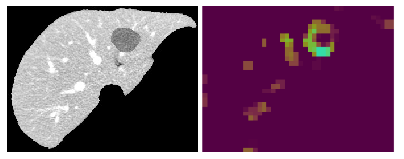

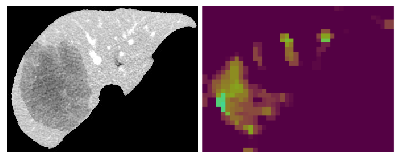

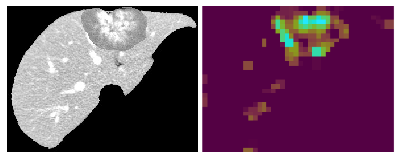

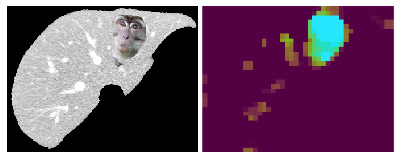

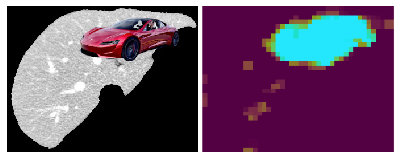

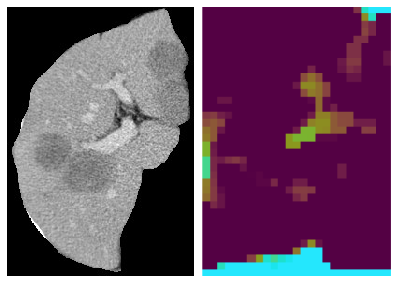

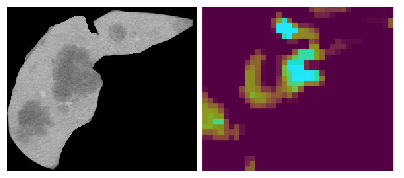

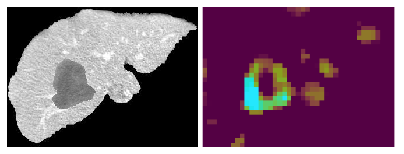

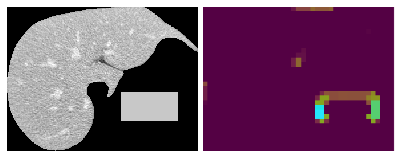

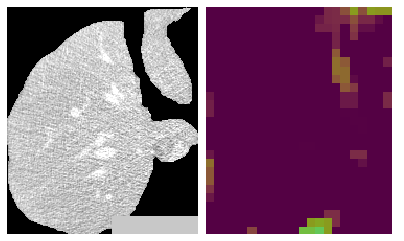

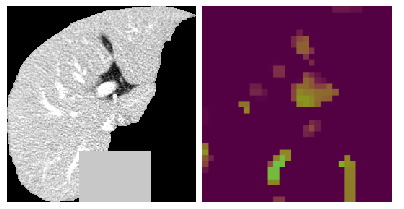

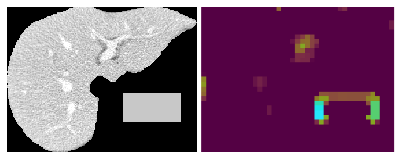

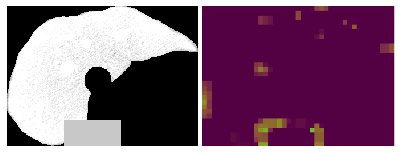

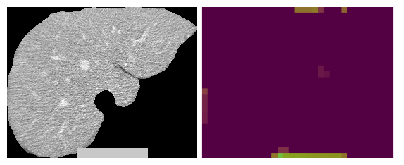

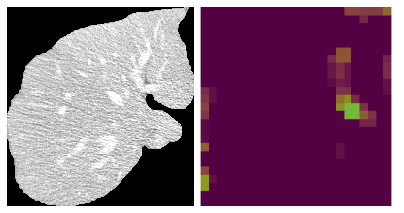

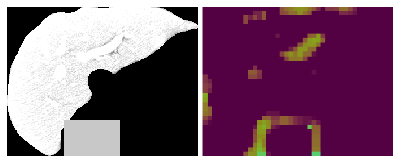

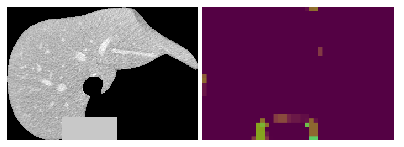

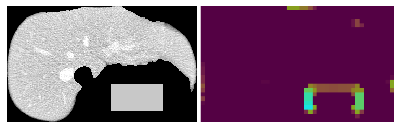

In [60]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
for image in synthetic_images[:]:

    image = image[np.ix_((image[...,0]>0).any(1), (image[...,0]>0).any(0))]
    image = cc(image)

    if device_ids:
        image = image.cuda(device_ids[0])

    image = image.unsqueeze(0)
    try:
        with torch.no_grad():
            score, occ_maps, part_scores = model.get_occlusion(image, 0)

        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)

        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        faco = img_orig.shape[0] / occ_img.shape[0]

        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))

        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        plt.figure(figsize=(7, 7))
        plt.imshow(canvas)
        plt.axis('off')
    except Exception as e:
        print(e)

# Localize Real Tumors

In [39]:
tumor_dir = os.path.join(Directories.DATA, 'tumors')
tumors = [cv2.imread(os.path.join(tumor_dir, name)) for name in os.listdir(tumor_dir)]

In [40]:
train_hdf5_fp = os.path.join(Directories.LITS, 'train.hdf5')
with h5py.File(train_hdf5_fp, 'r') as hf:
    image_dataset = hf['images'][40:60]
    target_dataset = hf['masks'][40:60]

tumors = []
for im in image_dataset:
    im = apply_ct_abdomen_filter(im)
    
    im = np.stack((im, im, im), axis=2)

    # Normalize between 0 and 1
    im = (im - im.min()) / (im.max() - im.min())
    im = im.astype(np.float32)
    tumors.append(im)

unet_filename = 'unet_liver_2020-08-13_15:52:08.pth'
is_cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if is_cuda_available else "cpu")

path_to_unet = os.path.join(Directories.CHECKPOINTS, unet_filename)
unet = UNet(pretrained=True)
unet.load_state_dict(torch.load(path_to_unet)['model_state_dict'])
if is_cuda_available: unet.to(device)

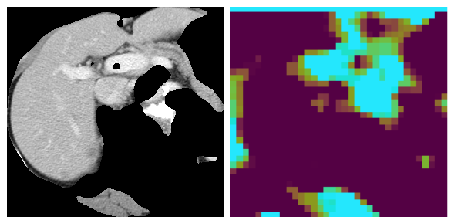

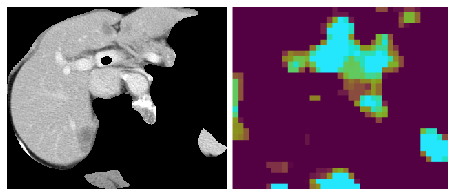

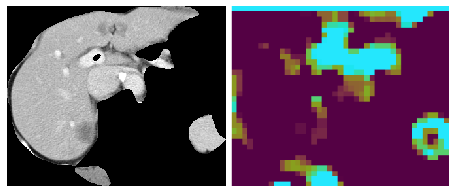

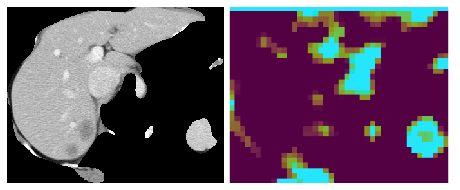

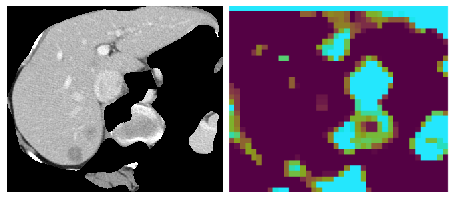

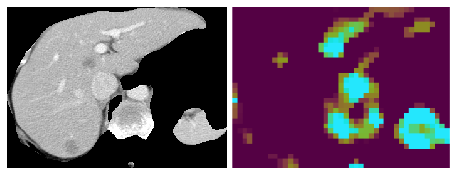

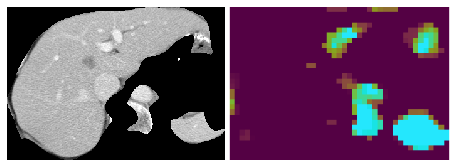

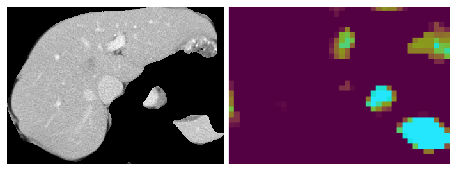

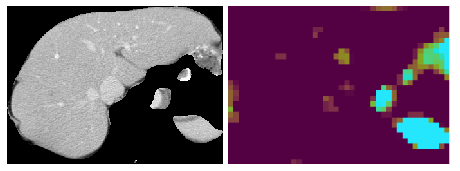

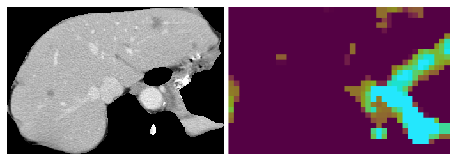

In [56]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
with torch.no_grad():
    for image in tumors[:10]:
        
        image = cc(image)
        
        if device_ids:
            image = image.cuda(device_ids[0])
        image = image.unsqueeze(0)
        
        out = unet(image)
        scores = F.softmax(out, dim=1)

        segmentations = torch.round(F.threshold(scores[:, 1, :, :], 0.9, 0))
        processed_images = segmentations.unsqueeze(1) * image
        
        seg_liver = processed_images.squeeze()
        image = seg_liver.unsqueeze(0)
        
        image = image.squeeze(0).permute(1,2,0).cpu().numpy()
        image = image[np.ix_((image[...,0]>0).any(1), (image[...,0]>0).any(0))]
        image = cc(image)
        image = image.unsqueeze(0)
        image = image.cuda()

        score, occ_maps, part_scores = model.get_occlusion(image, 0)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)
        
        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        faco = img_orig.shape[0] / occ_img.shape[0]
        
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        plt.figure(figsize=(8, 8))
        plt.imshow(canvas)
        plt.axis('off')
#         fp = f'{Directories.COMPOSITIONAL_NETS}/results/lits/train_without_occluder/test_{i}.png'
#         cv2.imwrite(fp, canvas)